In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread

In [2]:
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

## Загрузим изображение

In [3]:
image = imread("bat.jpeg", mode='RGB')

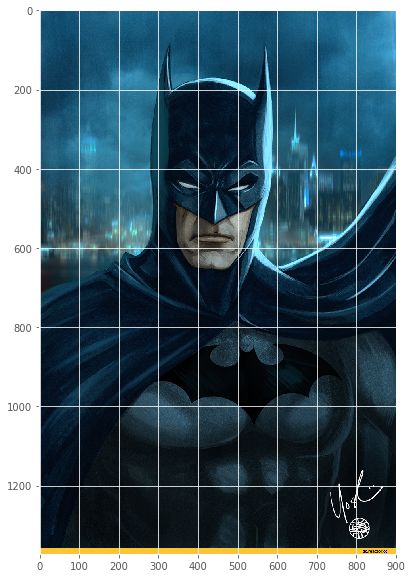

In [4]:
plt.imshow(image)

## Свёртки

Реализуйте функцию применяющую ядро kernel к изображению input_image. Для простоты, не будем делать padding, зафиксируем stride равным единице, а ядро свёртки будем считать квадратной матрицей (не трёхмерным тензором!) и приминять к каждому каналу независимо.

In [5]:
def conv2d(input_image, kernel, stride=(1,1,1), padding=False):
    
    k_h, k_w = kernel.shape
    h, w, d = input_image.shape
    
    # Начнём с того, что нам не хочется менять input_image 
    # Поэтому информацию из этой матрицы скопируем в
    # дополнительну матрицу, которая будет храниться в теле функции
    # Наша новая матрица tmp_image будет формироваться в зависимости от 
    # Входного значения padding:
    # Если padding = True, о нам необходимо расширить нашу временную матрицу
    # на дополнительные  k_h//2 влево и вправо, и на k_w//2 вверх и вниз 
   
    if padding:
        # инициализация матрицы нужных размеров, заполненной нулями
        tmp_image = np.zeros((h+k_h//2*2, w+k_w//2*2, d))
        
        tmp_image[k_h//2:k_h//2+h, k_w//2:k_w//2+w,:] = input_image
        
    else:
        tmp_image = input_image    
    
    # Перезаписываем значения h, w, d. Они понадобятся для вычисления
    # размера конечной матрицы.
    h, w, d = tmp_image.shape
    
    # Со stride дела  обстоят попроще, поскольку встроенный в python
    # итератор range может принимать на вход три переменных:
    # начальное значение, конечное(его и большие значения итератор не включит), шаг.
    # Таким образом нам просто необходимо добавить шаг в предыдущую реализацию. 
    
    h_stride, w_stride, d_stride = stride 
    
    
    # Последним штрихом будет вычисление размеров искомой свёрнутой матрицы.
    # Для этого достаточно понять, как посчитать число столбцов в матрице,
    # число строк мы посчитаем по аналогии.
    
    # Представим себе игру в змейку (к сожаленияю съедобных блоков нет).
    # Длина нашей змейки ровно k_w.
    # Она стоит в полную длинну в левом углу и идёт направо.
    # За один шаг она проходит w_stride делений. 
    # Расстояние между левой и правой стенкой w.
    # Вопрос в том, сколько шагов проделает змейка, прежде чем погибнет смертью храбрых?
    
    #   oo0 - Змий-Искуситель, размера k_w=3 и скорости w_stride=2, смотрит неодобряюще направо
    #           1          2          3  
    #           #12345678# #12345678# #12345678# 
    #           #oo0*****# #**oo0***# #****oo0*# 
    #           #12345678# #12345678# #12345678# 
                
    # Первое, что стоит заметить, что считать мы будем с головы змейки -> (w - k_w)
    # Второе, что чем больше шаг, тем ближе гибель, поэтому нужно разделить 
    # (w-k_w) на размер шага w_stride, причём нацело. 
    # Таким образом получим число шагов до столкновения со стенкой,
    # что ровно на 1 меньше,чем число столбцов в матрице,
    # поскольку эта формула не учитывает то, что змея покоилась в самом начале,
    # что аналогично первому положению окна, число же шагов змеи в этой задаче,
    # в точности  равно числу сдвигов окна свёртки.
    
    
    result = np.zeros(((h-k_h)//h_stride+1,  
                       (w-k_w)//w_stride+1,3))
    
    # enumerate - это ещё один полезный итератор,
    # в отличии от range на вход он принимает контейнер
    # и выплёвывает пары номер и значение из контейнера.
    
    for i, tmp_i in enumerate(range(0 ,h-k_h, h_stride)):
        for j, tmp_j in enumerate(range(0,w-k_w, w_stride)):
            for d in range(0,3, d_stride):
                result[i,j,d] = (tmp_image[tmp_i:tmp_i+k_h, tmp_j:tmp_j+k_w, d]*kernel).sum()
            
    return result      

Опишите ядро свёртки, выполняющее тождественное преобразование

In [6]:
identity_kernel = np.zeros((3,3))
identity_kernel[1,1] = 1

In [7]:
same_image = conv2d(image, identity_kernel, padding=True, stride=(1,1,2))

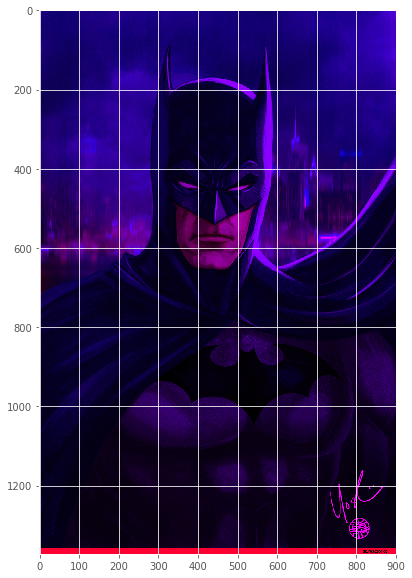

In [8]:
# Бэтмен двуканальный(без зелёного)
plt.imshow(same_image.astype(np.uint8))

Опишите ядро свёртки, выполняющее размытие

In [9]:
blur_kernel = np.ones((3,3))/9

In [10]:
blurry_image =  conv2d(image, blur_kernel, stride=(10,10,1))

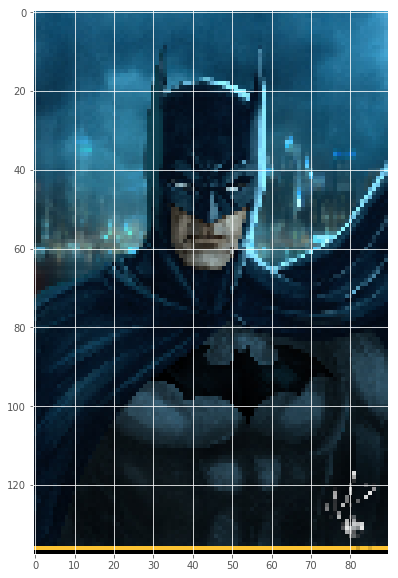

In [11]:
# Бэтмен смазано-пиксельный(блюр+большой страйд)
plt.imshow(blurry_image.astype(np.uint8))

А теперь подсветите границы объектов на изображении

In [12]:
# Я не помню как выглядит ядро выделющее границы,
# но можно схитрить - blur вычесть из identity,
# т.е. размазанность из изображению
edge_kernel = np.zeros((3,3))
edge_kernel = identity_kernel - blur_kernel

In [13]:
image.shape

(1373, 900, 3)

In [14]:
edge_image =  conv2d(image, edge_kernel, padding=True)

In [16]:
# избавляемся от шумовых артифактов при помощи усреднения(blur), границы это слабо похерит
edge_image = conv2d(edge_image, blur_kernel, padding=True)

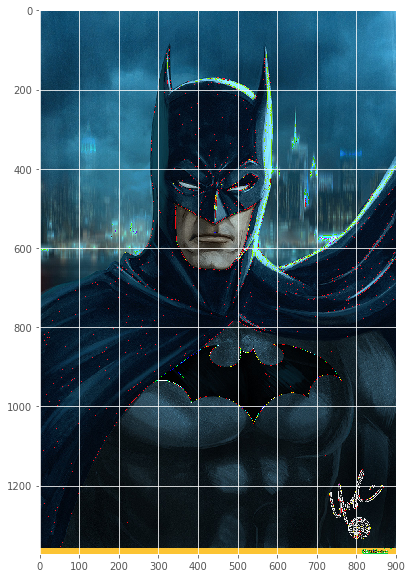

In [17]:
plt.imshow((edge_image + image).astype(np.uint8))

# Оффтоп, свёртки Кислотного-Зурабовича

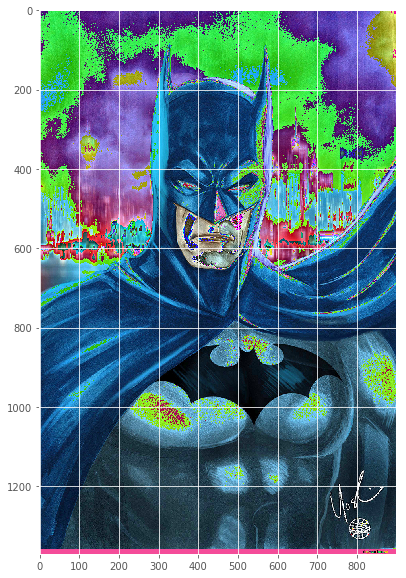

In [18]:
strong_identity = np.zeros((3,3))
strong_identity[1,1] = 3колличество 
str_i = conv2d(image, strong_identity)
plt.imshow((str_i).astype(np.uint8))

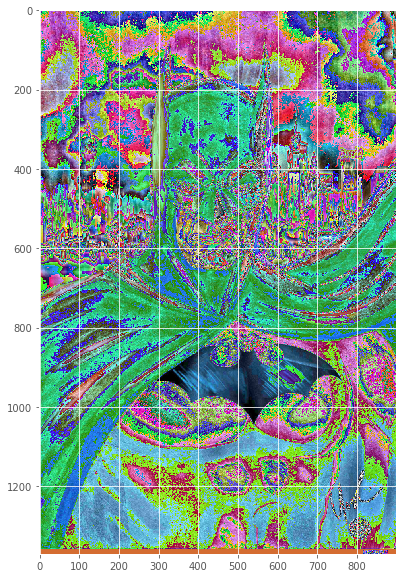

In [19]:
strange_blur = np.ones((3,3))
strange_blur[1,1] = 3
str_i = conv2d(image, strange_blur)
plt.imshow((str_i).astype(np.uint8))